## Conditional Graph

### What is a conditional Graph?

A conditional graph is a workflow graph where the path taken between nodes is not fixed, but instead depends on some condition or logic evaluated at runtime. This makes it different from a sequential graph, where steps follow a fixed order.

 In the Context of LLMs and LangGraph
When using LangGraph with LLMs, a conditional graph allows you to:
- Dynamically route prompts, tools, or actions based on LLM output.
- Build intelligent agents that can plan, reflect, or retry actions.
- Introduce logic-based control flow, like loops, branches, and early exits.

### How does it work?

Each node in a LangGraph can:
- Produce output and modify state
- Include conditional logic that decides where to go next
- LangGraph allows you to define edge functions that evaluate the current state and return the name of the next node.

### Example Flow:

Imagine a customer support agent:

```
Start
 └──► "Classify Query" (LLM: is it billing, tech, or other?)
          ├──► "Billing Response" (if billing)
          ├──► "Tech Troubleshooter" (if technical issue)
          └──► "Escalate to Human" (if unclear or other)

```

Each transition is conditional, based on the LLM's classification result.

### Common Use Cases:

1. Multi-step agents with tool selection
LLM decides: Should I call a calculator, search tool, or ask the user for clarification?

2. Dynamic prompt chains
Based on confidence or presence of an answer, the model either proceeds, re-asks, or escalates.

3. Retry or fallback mechanisms
If a generation fails validation, the graph loops back and tries a different approach or prompt.
4. Decision trees powered by LLMs
LLM determines the path, but LangGraph enforces the structure and state tracking.

### Why does conditional graphs matter in LLM workflows?

- **Improved control & reliability:** Instead of chaining prompts blindly, you can shape behavior.
- **Efficient resource use:** Avoids unnecessary tool calls or prompt steps.
- **Supports complex tasks:** Enables reasoning, planning, retries, and self-reflection loops.

In brief, a conditional graph in LangGraph lets you build flexible, intelligent, and controllable LLM workflows by defining paths that change based on model output or state. It’s a key pattern for building LLM agents, AI copilots, and automated pipelines that can adapt and reason over tasks.

In [1]:
# Install libraries
!pip install -q -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 6.1 MB/s eta 0:00:00


**NOTE!** Since Google Colab is used to execute and run this whole set of notebooks, we have to first install the necessary libraries.

Down below we will be implementing a very basic calculator which will either perform an addition or subtraction operation based on a given condition.

In [2]:
# Import libraries
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [3]:
class AgentState(TypedDict):
  num1: int
  operation: str
  num2: int
  result: int

In [4]:
def adder(state: AgentState) -> AgentState:
  """
  This is a node to add up numbers.

  Args:
    state = the current state of the agent

  Returns:
    the next state of the agent
    """
  state["result"] = state["num1"] + state["num2"]
  return state

In [5]:
def subtractor(state: AgentState) -> AgentState:
  """
  This is a node to subtract numbers.

  Args:
    state = the current state of the agent

  Returns:
    the next state of the agent
    """
  state["result"] = state["num1"] - state["num2"]
  return state

In [6]:
def pick_next_node(state: AgentState) -> str:
  """
  This is a node to pick the next node to go to.

  Args:
    state = the current state of the agent

  Returns:
    operation to go with
    """
  if state["operation"] == "+":
    return "addition_operation"
  elif state["operation"] == "-":
    return "subtraction_operation"
  else:
    return "Invalid Operation!"

In [7]:
# Initialize graph
graph = StateGraph(AgentState)

# Add nodes to the graph
graph.add_node("addition_node", adder)
graph.add_node("subtraction_node", subtractor)
graph.add_node("router", lambda state:state)  # the lambda in this case is referred to as  passthrough function

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    pick_next_node,
    {"addition_operation": "addition_node",
     "subtraction_operation": "subtraction_node"}
)

graph.add_edge("addition_node", END)
graph.add_edge("subtraction_node", END)

# Compile graph
app = graph.compile()

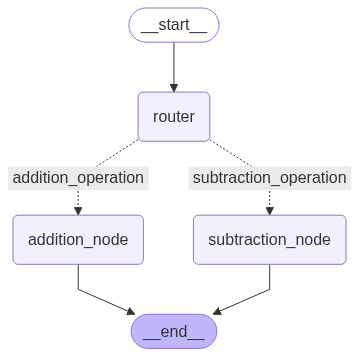

In [8]:
app

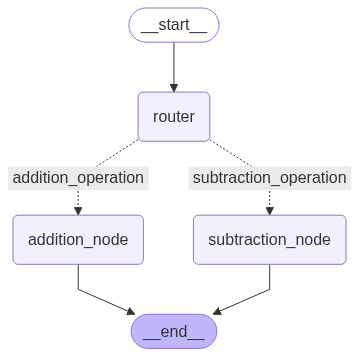

In [9]:
# OR alternatively as you may already know
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
state_1 = AgentState(num1=10, operation="+", num2=5)
app.invoke(state_1)

{'num1': 10, 'operation': '+', 'num2': 5, 'result': 15}

In [12]:
state_2 = AgentState(num1=10, operation="-", num2=5)
app.invoke(state_2)

{'num1': 10, 'operation': '-', 'num2': 5, 'result': 5}